In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import model_from_json

In [2]:
def iou_metric(y_true, y_pred):
    # Ensure they are binary
    y_pred = np.round(y_pred)
    
    intersection = np.sum(np.abs(y_true * y_pred))
    union = np.sum(np.abs(y_true) + np.abs(y_pred)) - intersection
    iou = intersection / (union + 1e-7)  # Add epsilon to avoid division by zero
    return iou

def dice_coefficient(y_true, y_pred):
    # Ensure they are binary
    y_pred = np.round(y_pred)
    
    intersection = np.sum(np.abs(y_true * y_pred))
    dice = (2. * intersection) / (np.sum(np.abs(y_true)) + np.sum(np.abs(y_pred)) + 1e-7)  # Add epsilon to avoid division by zero
    return dice

# mAP metric
def mAP_metric(y_true, y_pred):
    # Ensure they are binary
    y_pred = np.round(y_pred)
    
    # Compute the confusion matrix
    TP = np.sum(y_true * y_pred)
    FP = np.sum(y_pred) - TP
    FN = np.sum(y_true) - TP
    TN = np.sum((1 - y_true) * (1 - y_pred))
    
    # Compute precision and recall
    precision = TP / (TP + FP + 1e-7)  # Add epsilon to avoid division by zero
    recall = TP / (TP + FN + 1e-7)  # Add epsilon to avoid division by zero
    
    return precision, recall

In [ ]:
# Load the model architecture and weights
with open('../models_segmentation/EX.json', 'r') as json_file:
    model_json = json_file.read()
model_EX = model_from_json(model_json)
model_EX.load_weights('../models_segmentation/EX.weights.h5')

model_EX.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy', iou_metric, dice_coefficient])

with open('../models_segmentation/SE.json', 'r') as json_file:
    model_json = json_file.read()
model_SE = model_from_json(model_json)
model_SE.load_weights('../models_segmentation/SE.weights.h5')

model_SE.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', iou_metric, dice_coefficient])

with open('../models_segmentation/HE.json', 'r') as json_file:
    model_json = json_file.read()
model_HE = model_from_json(model_json)
model_HE.load_weights('../models_segmentation/HE.weights.h5')

model_HE.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy', iou_metric, dice_coefficient])

with open('../models_segmentation/MA.json', 'r') as json_file:
    model_json = json_file.read()
model_MA = model_from_json(model_json)
model_MA.load_weights('../models_segmentation/MA.weights.h5')

model_MA.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy', iou_metric, dice_coefficient])

# DDR dataset

### EX

In [ ]:
def load_data_EX(image_dir, mask_dir, image_size):
    images = []
    masks = []
    
    # Loop through all image files
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            # Get the base name (e.g., 'H0001' from 'H0001.jpg')
            base_name = os.path.splitext(filename)[0]
            
            # Construct the corresponding mask filename
            mask_filename = f"{base_name}.tif"
            
            # Check if the corresponding mask exists
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, mask_filename)
        
            if os.path.exists(mask_path):
                # Load and resize the image and mask
                img = load_img(img_path, target_size=image_size)
                mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
                
                # Convert to numpy arrays
                img_array = img_to_array(img) / 255.0  # Normalize the image between 0 and 1
                mask_array = img_to_array(mask) / 255.0  # Mask is binary
                
                if mask_array.max() <= 0:
                    print(f"Skipping {filename} as mask is empty.")
                    continue
                
                # Append the arrays to the lists
                images.append(img_array)
                masks.append(mask_array)
            else:
                print(f"Skipping {filename} as no corresponding mask was found.")
    
    # Convert the lists to numpy arrays
    return np.array(images), np.array(masks)

In [ ]:
image_dir = "path/to/images"
mask_dir = "path/to/images/EX"

# Image size (height, width, channels)
image_size = (256, 256)

images, masks = load_data_EX(image_dir, mask_dir, image_size)

In [ ]:
results = model_EX.predict(images)
results_binary = (results > 0.1).astype(int)

In [ ]:
ious = []
dices = []

# Loop over the test set
for i in range(len(images)):
    true_mask = masks[i]  # Ground truth mask
    pred_mask = results_binary[i]  # Predicted mask
    
    # Calculate IoU and Dice for the current image
    iou = iou_metric(true_mask, pred_mask)
    dice = dice_coefficient(true_mask, pred_mask)
    
    ious.append(iou)
    dices.append(dice)

# Compute the average IoU and Dice over the entire test set
average_iou = np.mean(ious)
average_dice = np.mean(dices)

print(f"Average IoU on test set: {average_iou}")
print(f"Average Dice Coefficient on test set: {average_dice}")

In [ ]:
# 150, 150
image = images[150]  # Original test image
true_mask = masks[150]  # Ground truth mask
pred_mask = results[150]  # Predict mask
pred_mask_binary = results_binary[150]  # Convert to binary

# Function to visualize image, ground truth mask, and predicted mask
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Ground truth mask
plt.subplot(2, 2, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 3)
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 4)
plt.imshow(pred_mask_binary.squeeze(), cmap='gray')
plt.title("Predicted Mask Threshold")
plt.axis('off')

plt.show()

In [ ]:
# Flatten the masks and predictions
y_true = masks.flatten()  # Flatten ground truth masks
y_pred = results.flatten()  # Flatten predicted probabilities (before thresholding)

# Calculate AUC
auc_score = roc_auc_score(y_true, y_pred)
print("AUC-ROC Score:", auc_score)

# Accuracy
accuracy = accuracy_score(y_true, y_pred > 0.5)
print("Accuracy:", accuracy)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

### SE

In [ ]:
def load_data_SE(image_dir, mask_dir, image_size):
    images = []
    masks = []
    
    # Loop through all image files
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            # Get the base name (e.g., 'H0001' from 'H0001.jpg')
            base_name = os.path.splitext(filename)[0]
            
            # Construct the corresponding mask filename
            mask_filename = f"{base_name}.tif"
            
            # Check if the corresponding mask exists
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, mask_filename)
        
            if os.path.exists(mask_path):
                # Load and resize the image and mask
                img = load_img(img_path, target_size=image_size)
                mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
                
                # Convert to numpy arrays
                img_array = img_to_array(img) / 255.0  # Normalize the image between 0 and 1
                mask_array = img_to_array(mask) / 255.0  # Mask is binary
                
                if mask_array.max() <= 0:
                    print(f"Skipping {filename} as mask is empty.")
                    continue
                
                # Append the arrays to the lists
                images.append(img_array)
                masks.append(mask_array)
            else:
                print(f"Skipping {filename} as no corresponding mask was found.")
    
    # Convert the lists to numpy arrays
    return np.array(images), np.array(masks)

In [ ]:
image_dir = "path/to/images"
mask_dir = "path/to/images/SE"
# Image size (height, width, channels)
image_size = (256, 256)

images, masks = load_data_SE(image_dir, mask_dir, image_size)

In [ ]:
results = model_SE.predict(images)
results_binary = (results > 0.5).astype(int)

In [ ]:
ious = []
dices = []

# Loop over the test set
for i in range(len(images)):
    true_mask = masks[i]  # Ground truth mask
    pred_mask = results_binary[i]  # Predicted mask
    
    # Calculate IoU and Dice for the current image
    iou = iou_metric(true_mask, pred_mask)
    dice = dice_coefficient(true_mask, pred_mask)
    
    ious.append(iou)
    dices.append(dice)

# Compute the average IoU and Dice over the entire test set
average_iou = np.mean(ious)
average_dice = np.mean(dices)

print(f"Average IoU on test set: {average_iou}")
print(f"Average Dice Coefficient on test set: {average_dice}")

In [ ]:
import matplotlib.pyplot as plt
# 36, 36
image = images[200]  # Original test image
true_mask = masks[200]  # Ground truth mask
pred_mask = model_SE.predict(np.expand_dims(image, axis=0))  # Predict mask
pred_mask_binary = (pred_mask > 0.1).astype(int)  # Convert to binary

# Function to visualize image, ground truth mask, and predicted mask
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Ground truth mask
plt.subplot(2, 2, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 3)
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 4)
plt.imshow(pred_mask_binary.squeeze(), cmap='gray')
plt.title("Predicted Mask Threshold")
plt.axis('off')

plt.show()

In [ ]:
# Flatten the masks and predictions
y_true = masks.flatten()  # Flatten ground truth masks
y_pred = results_binary.flatten()  # Flatten predicted probabilities (before thresholding)

# Calculate AUC
auc_score = roc_auc_score(y_true, y_pred)
print("AUC-ROC Score:", auc_score)

# Accuracy
accuracy = accuracy_score(y_true, y_pred > 0.5)
print("Accuracy:", accuracy)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

### HE

In [ ]:
def measure_of_enhancement(img, k=8):
    """
    Calculates the Measure of Enhancement (EME) for the given image.
    Higher EME indicates better contrast.
    :param img: Input image in RGB format.
    :param k: Tile size (default is 8).
    :return: EME value
    """
    height, width, _ = img.shape
    eme = 0.0
    for i in range(0, height, k):
        for j in range(0, width, k):
            tile = img[i:i+k, j:j+k]
            min_val = np.min(tile)
            max_val = np.max(tile)
            if min_val > 0:
                eme += 20 * np.log10(max_val / min_val)
    eme /= ((height // k) * (width // k))
    return eme

def enhance_img(img, limit=6.0, grid=(8, 8)):
    # Step 1: Apply median filter with a 3x3 kernel
    img = cv2.medianBlur(img.astype(np.uint8), ksize=3)

    # Step 2: Convert to LAB color space
    lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab_img)

    # Step 3: Apply CLAHE on the Luminosity (L) channel with 8x8 tile grid
    clahe = cv2.createCLAHE(clipLimit=limit, tileGridSize=grid)
    l = clahe.apply(l)

    # Step 4: Merge CLAHE enhanced L with original A and B channels
    lab_img = cv2.merge((l, a, b))

    # Step 5: Convert back to RGB color space
    enhanced_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2RGB)
    
    return enhanced_img

def load_data_HE(image_dir, mask_dir, image_size):
    images = []
    masks = []
    
    # Loop through all image files
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            # Get the base name (e.g., 'H0001' from 'H0001.jpg')
            base_name = os.path.splitext(filename)[0]
            
            # Construct the corresponding mask filename
            mask_filename = f"{base_name}.tif"
            
            # Check if the corresponding mask exists
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, mask_filename)
        
            if os.path.exists(mask_path):
                # Load and resize the image and mask
                img = load_img(img_path, target_size=image_size)
                mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
                
                # Enhance the image
                img = img_to_array(img)
                img = enhance_img(img)
                
                print(f"Enhanced image {filename} with EME: {measure_of_enhancement(img)}")
                
                # Convert to numpy arrays
                img_array = img / 255.0  # Image is normalized
                mask_array = img_to_array(mask) / 255.0  # Mask is binary
                
                if mask_array.max() <= 0:
                    print(f"Skipping {filename} as mask is empty.")
                    continue
                
                # Append the arrays to the lists
                images.append(img_array)
                masks.append(mask_array)
            else:
                print(f"Skipping {filename} as no corresponding mask was found.")
        print()
    
    # Convert the lists to numpy arrays
    return np.array(images), np.array(masks)

In [ ]:
image_dir = "path/to/images"
mask_dir = "path/to/images/HE"

# Image size (height, width, channels)
image_size = (256, 256)

images, masks = load_data_HE(image_dir, mask_dir, image_size)

In [ ]:
results = model_HE.predict(images)
results_binary = (results > 0.5).astype(int)

In [ ]:
ious = []
dices = []

# Loop over the test set
for i in range(len(images)):
    true_mask = masks[i]  # Ground truth mask
    pred_mask = results_binary[i]  # Predicted mask
    
    # Calculate IoU and Dice for the current image
    iou = iou_metric(true_mask, pred_mask)
    dice = dice_coefficient(true_mask, pred_mask)
    
    ious.append(iou)
    dices.append(dice)

# Compute the average IoU and Dice over the entire test set
average_iou = np.mean(ious)
average_dice = np.mean(dices)

print(f"Average IoU on test set: {average_iou*100}%")
print(f"Average Dice Coefficient on test set: {average_dice*100}%")

In [ ]:
# 150, 150
image = images[12]  # Original test image
true_mask = masks[12]  # Ground truth mask
pred_mask_binary = results_binary[12]  # Predicted mask

# Function to visualize image, ground truth mask, and predicted mask
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Ground truth mask
plt.subplot(2, 2, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 3)
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 4)
plt.imshow(pred_mask_binary.squeeze(), cmap='gray')
plt.title("Predicted Mask Threshold")
plt.axis('off')

plt.show()

In [ ]:
# Flatten the masks and predictions
y_true = masks.flatten()  # Flatten ground truth masks
y_pred = results.flatten()  # Flatten predicted probabilities (before thresholding)

# Calculate AUC
auc_score = roc_auc_score(y_true, y_pred)
print("AUC-ROC Score %:", auc_score*100)

# Accuracy
accuracy = accuracy_score(y_true, y_pred > 0.5)
print("Accuracy %:", accuracy*100)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

### MA

In [ ]:
def get_mask(path, target_size):
    image = cv2.imread(path)
    image = cv2.resize(image, target_size)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert image to HSV (Hue, Saturation, Value) color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the red color range for masking
    lower_red = np.array([0, 100, 50])
    upper_red = np.array([12, 250, 250])
    mask1 = cv2.inRange(hsv_image, lower_red, upper_red)

    # lower_red2 = np.array([170, 120, 70])
    lower_red2 = np.array([10, 60, 70])
    upper_red2 = np.array([180, 255, 255])
    mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
    mask2 = cv2.bitwise_not(mask2)

    # Combine masks for red
    red_mask = mask1 + mask2
    
    # overlay the mask on the original image
    masked_image = cv2.bitwise_and(image_rgb, image_rgb, mask=red_mask)

    # overlay the mask on the original image
    red_mask_3ch = cv2.cvtColor(red_mask, cv2.COLOR_GRAY2BGR)
    
    mask = cv2.addWeighted(image_rgb, 0.7, red_mask_3ch, 0.3, 0)
    
    return mask

def load_data_MA(image_dir, mask_dir, image_size):
    images = []
    masks = []
    
    # Loop through all image files
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            # Get the base name (e.g., 'H0001' from 'H0001.jpg')
            base_name = os.path.splitext(filename)[0]
            
            # Construct the corresponding mask filename
            mask_filename = f"{base_name}.tif"
            
            # Check if the corresponding mask exists
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, mask_filename)
        
            if os.path.exists(mask_path):
                # Load and resize the image and mask
                img = get_mask(img_path, target_size=image_size)
                # img = load_img(img_path, target_size=image_size)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                
                if mask.max() == 0:
                    print(f"Skipping {filename} as no mask was found.")
                    continue 
                
                mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
                
                # Convert to numpy arrays
                img_array = img_to_array(img) / 255.0
                mask_array = img_to_array(mask) / 255.0  # Mask is binary
                
                # img_array = enhance_img(img_array) / 255.0  # Normalize the image between 0 and 1
                
                # Append the arrays to the lists
                images.append(img_array)
                masks.append(mask_array)
            else:
                print(f"Skipping {filename} as no corresponding mask was found.")
    
    # Convert the lists to numpy arrays
    return np.array(images), np.array(masks)

In [ ]:
image_dir = "path/to/images"
mask_dir = "path/to/images/MA"

# Image size (height, width, channels)
image_size = (256, 256)

images, masks = load_data_MA(image_dir, mask_dir, image_size)

In [ ]:
results = model_MA.predict(images)
results_binary = (results > 0.5).astype(int)

In [ ]:
ious = []
dices = []

# Loop over the test set
for i in range(len(images)):
    true_mask = masks[i]  # Ground truth mask
    pred_mask = results_binary[i]  # Predicted mask
    
    # Calculate IoU and Dice for the current image
    iou = iou_metric(true_mask, pred_mask)
    dice = dice_coefficient(true_mask, pred_mask)
    
    ious.append(iou)
    dices.append(dice)

# Compute the average IoU and Dice over the entire test set
average_iou = np.mean(ious)
average_dice = np.mean(dices)

print(f"Average IoU on test set: {average_iou}")
print(f"Average Dice Coefficient on test set: {average_dice}")

In [ ]:
# 150, 150
image = images[3]  # Original test image
true_mask = masks[3]  # Ground truth mask
pred_mask = results[3]  # Predicted mask
pred_mask_binary = results_binary[3]  # Predicted mask

# Function to visualize image, ground truth mask, and predicted mask
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Ground truth mask
plt.subplot(2, 2, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 3)
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 4)
plt.imshow(pred_mask_binary.squeeze(), cmap='gray')
plt.title("Predicted Mask Threshold")
plt.axis('off')

plt.show()

In [ ]:
# Flatten the masks and predictions
y_true = masks.flatten()  # Flatten ground truth masks
y_pred = results.flatten()  # Flatten predicted probabilities (before thresholding)

# Calculate AUC
auc_score = roc_auc_score(y_true, y_pred)
print("AUC-ROC Score:", auc_score)

# Accuracy
accuracy = accuracy_score(y_true, y_pred > 0.5)
print("Accuracy:", accuracy)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

# Test on IDRiD

### EX

In [4]:
def load_data_EX(image_dir, mask_dir, image_size):
    images = []
    masks = []
    
    # Loop through all image files
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            # Get the base name (e.g., 'H0001' from 'H0001.jpg')
            base_name = os.path.splitext(filename)[0]
            
            # Construct the corresponding mask filename
            mask_filename = f"{base_name}_EX.tif"
            
            # Check if the corresponding mask exists
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, mask_filename)
        
            if os.path.exists(mask_path):
                # Load and resize the image and mask
                img = load_img(img_path, target_size=image_size)
                # load mask as binary
                mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
                
                # Convert to numpy arrays
                img_array = img_to_array(img) / 255.0  # Normalize the image between 0 and 1
                mask_array = img_to_array(mask) / 255.0
                mask_array = (mask_array > 0).astype(np.float32) # Mask is binary
                
                if mask_array.max() <= 0:
                    print(f"Skipping {filename} as mask is empty.")
                    continue
                
                # Append the arrays to the lists
                images.append(img_array)
                masks.append(mask_array)
            else:
                print(f"Skipping {filename} as no corresponding mask was found.")
    
    # Convert the lists to numpy arrays
    return np.array(images), np.array(masks)

In [5]:
image_dir = "path/to/images"
mask_dir = "path/to/images/Hard Exudates"

image_size = (256, 256)

images, masks = load_data_EX(image_dir, mask_dir, image_size)

In [6]:
results = model_EX.predict(images)
results_binary = (results > 0.1).astype(int)

2024-12-13 12:20:05.100939: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-12-13 12:20:05.175813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 3s 675ms/step


In [7]:
ious = []
dices = []

# Loop over the test set
for i in range(len(images)):
    true_mask = masks[i]  # Ground truth mask
    pred_mask = results_binary[i]  # Predicted mask
    
    # Calculate IoU and Dice for the current image
    iou = iou_metric(true_mask, pred_mask)
    dice = dice_coefficient(true_mask, pred_mask)
    
    ious.append(iou)
    dices.append(dice)

# Compute the average IoU and Dice over the entire test set
average_iou = np.mean(ious)
average_dice = np.mean(dices)

print(f"Average IoU on test set: {average_iou}")
print(f"Average Dice Coefficient on test set: {average_dice}")

Average IoU on test set: 0.31253518762854454
Average Dice Coefficient on test set: 0.4535498302680706


1/1 [==============================] - 0s 169ms/step


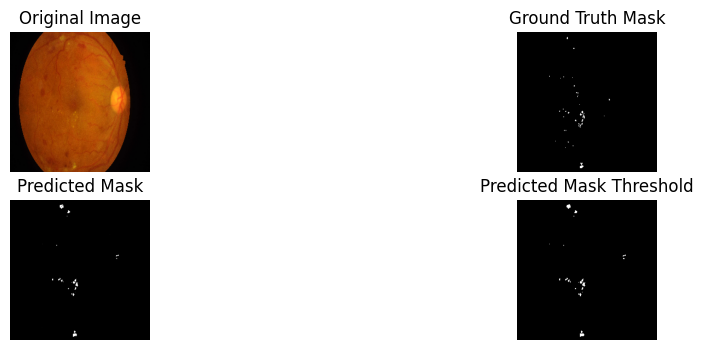

In [9]:
# 50, 50
image = images[50]  # Original test image
true_mask = masks[50]  # Ground truth mask
pred_mask = model_EX.predict(np.expand_dims(image, axis=0))  # Predict mask
pred_mask_binary = (pred_mask > 0.1).astype(int)  # Convert to binary

# Function to visualize image, ground truth mask, and predicted mask
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Ground truth mask
plt.subplot(2, 2, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 3)
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 4)
plt.imshow(pred_mask_binary.squeeze(), cmap='gray')
plt.title("Predicted Mask Threshold")
plt.axis('off')
plt.show()

In [ ]:
# Flatten the masks and predictions
y_true = masks.flatten()  # Flatten ground truth masks
y_pred = results_binary.flatten()  # Flatten predicted probabilities (before thresholding)

# Calculate AUC
auc_score = roc_auc_score(y_true, y_pred)
print("AUC-ROC Score:", auc_score)

# Accuracy
accuracy = accuracy_score(y_true, y_pred > 0.5)
print("Accuracy:", accuracy)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

### SE

In [ ]:
def load_data_SE(image_dir, mask_dir, image_size):
    images = []
    masks = []
    
    # Loop through all image files
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            base_name = os.path.splitext(filename)[0]
            
            mask_filename = f"{base_name}_SE.tif"
            
            # Check if the corresponding mask exists
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, mask_filename)
        
            if os.path.exists(mask_path):
                # Load and resize the image and mask
                img = load_img(img_path, target_size=image_size)
                # load mask as binary
                mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
                
                # Convert to numpy arrays
                img_array = img_to_array(img) / 255.0  # Normalize the image between 0 and 1
                mask_array = img_to_array(mask) / 255.0
                mask_array = (mask_array > 0).astype(np.float32) # Mask is binary
                
                # Append the arrays to the lists
                images.append(img_array)
                masks.append(mask_array)
            else:
                print(f"Skipping {filename} as no corresponding mask was found.")
    
    # Convert the lists to numpy arrays
    return np.array(images), np.array(masks)

In [ ]:
image_dir = "path/to/images"
mask_dir = "path/to/images/Soft Exudates"

image_size = (256, 256)

images, masks = load_data_SE(image_dir, mask_dir, image_size)

In [ ]:
results = model_SE.predict(images)
results_binary = (results > 0.1).astype(int)

In [ ]:
ious = []
dices = []

# Loop over the test set
for i in range(len(images)):
    true_mask = masks[i]  # Ground truth mask
    pred_mask = results_binary[i]  # Predicted mask
    
    # Calculate IoU and Dice for the current image
    iou = iou_metric(true_mask, pred_mask)
    dice = dice_coefficient(true_mask, pred_mask)
    
    ious.append(iou)
    dices.append(dice)

# Compute the average IoU and Dice over the entire test set
average_iou = np.mean(ious)
average_dice = np.mean(dices)

print(f"Average IoU on test set: {average_iou}")
print(f"Average Dice Coefficient on test set: {average_dice}")

In [ ]:
# 50, 50
image = images[50]  # Original test image
true_mask = masks[50]  # Ground truth mask
pred_mask = model_SE.predict(np.expand_dims(image, axis=0))  # Predict mask
pred_mask_binary = (pred_mask > 0.1).astype(int)  # Convert to binary

# Function to visualize image, ground truth mask, and predicted mask
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Ground truth mask
plt.subplot(2, 2, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 3)
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 4)
plt.imshow(pred_mask_binary.squeeze(), cmap='gray')
plt.title("Predicted Mask Threshold")
plt.axis('off')
plt.show()

In [ ]:
# Flatten the masks and predictions
y_true = masks.flatten()  # Flatten ground truth masks
y_pred = results_binary.flatten()  # Flatten predicted probabilities (before thresholding)

# Calculate AUC
auc_score = roc_auc_score(y_true, y_pred)
print("AUC-ROC Score:", auc_score)

# Accuracy
accuracy = accuracy_score(y_true, y_pred > 0.5)
print("Accuracy:", accuracy)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

### HE

In [ ]:
def load_data_HE(image_dir, mask_dir, image_size):
    images = []
    masks = []
    
    # Loop through all image files
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            base_name = os.path.splitext(filename)[0]
            
            mask_filename = f"{base_name}_HE.tif"
            
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, mask_filename)
        
            if os.path.exists(mask_path):
                img = load_img(img_path, target_size=image_size)
                mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
                
                # Enhance the image
                img = img_to_array(img)
                img = enhance_img(img)
                
                print(f"Enhanced image {filename} with EME: {measure_of_enhancement(img)}")
                
                # Convert to numpy arrays
                img_array = img / 255.0  # Image is normalized
                mask_array = img_to_array(mask) / 255.0  # Mask is binary
                mask_array = (mask_array > 0).astype(np.float32) # Mask is binary
                
                if mask_array.max() <= 0:
                    print(f"Skipping {filename} as mask is empty.")
                    continue
                
                # Append the arrays to the lists
                images.append(img_array)
                masks.append(mask_array)
            else:
                print(f"Skipping {filename} as no corresponding mask was found.")
        print()
    
    # Convert the lists to numpy arrays
    return np.array(images), np.array(masks)

In [ ]:
image_dir = "path/to/images"
mask_dir = "path/to/images/Haemmorages"

image_size = (256, 256)

images, masks = load_data_HE(image_dir, mask_dir, image_size)

In [ ]:
results = model_HE.predict(images)
results_binary = (results > 0.1).astype(int)

In [ ]:
ious = []
dices = []

# Loop over the test set
for i in range(len(images)):
    true_mask = masks[i]  # Ground truth mask
    pred_mask = results_binary[i]  # Predicted mask
    
    # Calculate IoU and Dice for the current image
    iou = iou_metric(true_mask, pred_mask)
    dice = dice_coefficient(true_mask, pred_mask)
    
    ious.append(iou)
    dices.append(dice)

# Compute the average IoU and Dice over the entire test set
average_iou = np.mean(ious)
average_dice = np.mean(dices)

print(f"Average IoU on test set: {average_iou*100}%")
print(f"Average Dice Coefficient on test set: {average_dice*100}%")

In [ ]:
# 3, 3
image = images[10]  # Original test image
true_mask = masks[10]  # Ground truth mask
pred_mask = model_HE.predict(np.expand_dims(image, axis=0))  # Predict mask
pred_mask_binary = (pred_mask > 0.1).astype(int)  # Convert to binary

# Function to visualize image, ground truth mask, and predicted mask
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Ground truth mask
plt.subplot(2, 2, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 3)
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 4)
plt.imshow(pred_mask_binary.squeeze(), cmap='gray')
plt.title("Predicted Mask Threshold")
plt.axis('off')
plt.show()

In [ ]:
# Flatten the masks and predictions
y_true = masks.flatten()  # Flatten ground truth masks
y_pred = results_binary.flatten()  # Flatten predicted probabilities (before thresholding)

# Calculate AUC
auc_score = roc_auc_score(y_true, y_pred)
print("AUC-ROC Score %:", auc_score*100)

# Accuracy
accuracy = accuracy_score(y_true, y_pred > 0.5)
print("Accuracy %:", accuracy*100)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

### MA

In [ ]:
def load_data_MA(image_dir, mask_dir, image_size):
    images = []
    masks = []
    
    # Loop through all image files
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            # Get the base name (e.g., 'H0001' from 'H0001.jpg')
            base_name = os.path.splitext(filename)[0]
            
            # Construct the corresponding mask filename
            mask_filename = f"{base_name}_MA.tif"
            
            # Check if the corresponding mask exists
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, mask_filename)
        
            if os.path.exists(mask_path):
                # Load and resize the image and mask
                img = load_img(img_path, target_size=image_size)
                img = get_mask(img_path, target_size=image_size)
                
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if mask.max() == 0:
                    print(f"Skipping {filename} as no mask was found.")
                    continue 
                
                mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
                
                # Convert to numpy arrays
                img_array = img_to_array(img)
                img_array = img_array / 255.0  # Image is normalized
                
                mask_array = img_to_array(mask) / 255.0
                mask_array = (mask_array > 0).astype(np.float32) # Mask is binary
                
                # Append the arrays to the lists
                images.append(img_array)
                masks.append(mask_array)
            else:
                print(f"Skipping {filename} as no corresponding mask was found.")
    
    # Convert the lists to numpy arrays
    return np.array(images), np.array(masks)

In [ ]:
image_dir = "path/to/images"
mask_dir = "path/to/images/Microaneurysms"

image_size = (256, 256)

images, masks = load_data_MA(image_dir, mask_dir, image_size)

In [ ]:
ious = []
dices = []

# Loop over the test set
for i in range(len(images)):
    true_mask = masks[i]  # Ground truth mask
    pred_mask = results_binary[i]  # Predicted mask
    
    # Calculate IoU and Dice for the current image
    iou = iou_metric(true_mask, pred_mask)
    dice = dice_coefficient(true_mask, pred_mask)
    
    ious.append(iou)
    dices.append(dice)

# Compute the average IoU and Dice over the entire test set
average_iou = np.mean(ious)
average_dice = np.mean(dices)

print(f"Average IoU on test set: {average_iou}")
print(f"Average Dice Coefficient on test set: {average_dice}")

In [ ]:
# 3, 3
image = images[24]  # Original test image
true_mask = masks[24]  # Ground truth mask
pred_mask = results[24]  # Predicted mask
pred_mask_binary = results_binary[24]  # Predicted mask

# Function to visualize image, ground truth mask, and predicted mask
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Ground truth mask
plt.subplot(2, 2, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 3)
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 4)
plt.imshow(pred_mask_binary.squeeze(), cmap='gray')
plt.title("Predicted Mask Threshold")
plt.axis('off')
plt.show()

In [ ]:
# Flatten the masks and predictions
y_true = masks.flatten()  # Flatten ground truth masks
y_pred = results_binary.flatten()  # Flatten predicted probabilities (before thresholding)

# Calculate AUC
auc_score = roc_auc_score(y_true, y_pred)
print("AUC-ROC Score:", auc_score)

# Accuracy
accuracy = accuracy_score(y_true, y_pred > 0.5)
print("Accuracy:", accuracy)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()